# Laboratorio final - Modelos de Credit Scoring


In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
#!pip install imblearn

## Algunas librerias adicionales

In [3]:
# settings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Cargamos la data

In [4]:
df1 = pd.read_csv('application_record.csv')
df2 = pd.read_csv('credit_record.csv')

**ID:**	Client number	
**CODE_GENDER:**	Gender	
**FLAG_OWN_CAR:**	Is there a car	
**FLAG_OWN_REALTY:**	Is there a property	
**CNT_CHILDREN:**	Number of children	
**AMT_INCOME_TOTAL:**	Annual income	
**NAME_INCOME_TYPE:**	Income category	
**NAME_EDUCATION_TYPE:**	Education level	
**NAME_FAMILY_STATUS:**	Marital status	
**NAME_HOUSING_TYPE:**	Way of living	
**DAYS_BIRTH:**	Birthday 	Count backwards from current day (0), -1 means yesterday
**DAYS_EMPLOYED:**	Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
**FLAG_MOBIL:**	Is there a mobile phone	
**FLAG_WORK_PHONE:**	Is there a work phone	
**FLAG_PHONE:**	Is there a phone	
**FLAG_EMAIL:**	Is there an email	
**OCCUPATION_TYPE:**	Occupation	
**CNT_FAM_MEMBERS:**	Family size	

In [5]:
#revisamos el dataset
df1.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
#validamos la estructura de los datos
df1.shape

(438557, 18)

In [7]:
#validamos el nivel de clientes en la base de datos
print('Nro de IDs distintos:', df1.ID.nunique())
print('Nro de IDs distintos:', df1['ID'].nunique())

Nro de IDs distintos: 438510
Nro de IDs distintos: 438510


**ID:**	Client number	

**MONTHS_BALANCE:**	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on

**STATUS:**	Status
0: 1-29 days past due 

1: 30-59 days past due 

2: 60-89 days overdue 

3: 90-119 days overdue 

4: 120-149 days overdue 

5: Overdue or bad debts, write-offs for more than 150 days 

C: paid off that month 

X: No loan for the month

In [8]:
df2.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


### limpando los dados

In [9]:
# Verificando la presencia de null values
df1.isnull().sum().sum()

134203

In [10]:
df1.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [11]:
# Verificando la presencia de null values
df2.isnull().sum().sum()

0

In [12]:
df2.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [13]:
# Verificando la presencia de NA
df1.isnull().values.any()

True

In [14]:
df1[df1.OCCUPATION_TYPE.isnull()]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438549,6840098,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438550,6840100,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438551,6840102,F,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0


In [15]:
#Removiendo los Null/NA
df1 = df1.dropna()

In [16]:
#verificando si queda algun Null/NA
df1.isnull().values.any()

False

### Verificando el numero de lineas restantes
¿Cuántos registros nos quedan?

In [17]:
df1.shape[0]

304354

In [18]:
# Application record
index = df1.index
number_of_rows = len(index)
print(number_of_rows)

304354


In [19]:
# Credit record
index = df2.index
number_of_rows = len(index)
print(number_of_rows)

1048575


### Juntando las dos bases de datos

In [20]:
df1[df1.ID.duplicated()].head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
422660,7052783,M,Y,Y,2,166500.0,Working,Secondary / secondary special,Married,House / apartment,-15883,-2697,1,1,0,1,Managers,4.0
424480,7053557,M,Y,Y,1,193500.0,Working,Secondary / secondary special,Married,House / apartment,-10439,-2250,1,1,0,0,Core staff,3.0
425306,7023651,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229,-1209,1,0,0,0,Accountants,1.0
425724,7213374,M,N,N,1,270000.0,Commercial associate,Higher education,Married,House / apartment,-14317,-1052,1,0,1,0,Managers,3.0
426198,7089090,F,N,Y,1,189000.0,Commercial associate,Incomplete higher,Married,House / apartment,-10045,-1730,1,0,0,0,Core staff,3.0


In [21]:

df3 = pd.merge(df1, df2, on='ID')
df3.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-1,C
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-2,C
3,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-3,C
4,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-4,C


In [22]:
#Verificando la cantidad de datos que tenemos luego del merge
index = df3.index
number_of_rows = len(index)
print(number_of_rows)

537667


* Es interesante notar que la base de datos aumentó, porque se pueden haber generado valores duplicados. Vamos a removerlos:

In [23]:
#verificando si queda algun Null/NA
df3.isnull().values.any()

False

In [24]:
df3[df3.ID.duplicated()]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-1,C
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-2,C
3,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-3,C
4,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-4,C
5,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-5,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537662,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0
537663,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-10,2
537664,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-11,1
537665,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-12,0


In [25]:
df3[df3.ID == 5150337]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
537653,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,0,0
537654,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-1,0
537655,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-2,0
537656,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-3,0
537657,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-4,0
537658,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-5,0
537659,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-6,0
537660,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-7,0
537661,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-8,0
537662,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,-9,0


In [26]:

#Eliminando los ID duplicados
df3 = df3.drop_duplicates('ID',keep='first')



In [27]:
#Veamos los datos luego del merge y de la limpieza de duplicados
df3[df3.ID == 5150337]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
537653,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,Laborers,1.0,0,0


### Transformando las variables en dummies

In [28]:
#Eliminando la variable CODE_GENDER para evitar un sesgo sexista en la base de datos
df3 = df3.drop(columns=['CODE_GENDER'])
df3.head(3)

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008806,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C
30,5008808,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
35,5008809,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,X


In [29]:
# Trasnformando todos los valores Y o N en dummies, siendo 1 para Y
dummy1 = pd.get_dummies(df3.FLAG_OWN_CAR)
df3['FLAG_OWN_CAR'] = dummy1['Y']

dummy2 = pd.get_dummies(df3.FLAG_OWN_REALTY)
df3['FLAG_OWN_REALTY'] = dummy2['Y']


#Vemos las clases de las variables categoricas
#print(df3['NAME_INCOME_TYPE'].unique())

#Vemos las clases de las variables categoricas
#print(df3['NAME_EDUCATION_TYPE'].unique())

#Vemos las clases de las variables categoricas
#print(df3['OCCUPATION_TYPE'].unique())

#Vemos las clases de las variables categoricas
#print(df3['STATUS'].unique())




In [30]:
df3.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008806,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C
30,5008808,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
35,5008809,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,X
40,5008810,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C
67,5008811,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C


## Intentaremos comprender la capacidad de pago de las personas y ponerla en categorías

Text(0.5, 1.0, 'Casa')

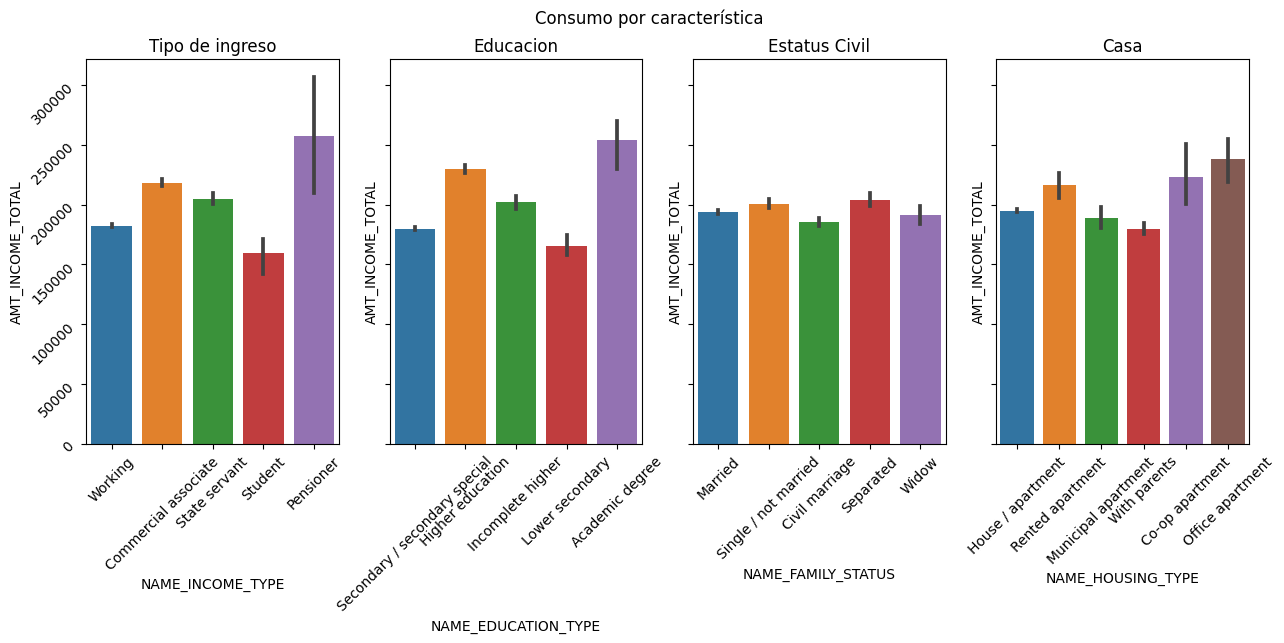

In [31]:
#### Veamos cómo son los niveles de consumo por categorías sociales


fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('Consumo por característica')

# Tipo Ingreso
sns.barplot(ax=axes[0], x=df3.NAME_INCOME_TYPE, y=df3.AMT_INCOME_TOTAL).tick_params(labelrotation=45)
axes[0].set_title("Tipo de ingreso")


# Escolaridad
sns.barplot(ax=axes[1], x=df3.NAME_EDUCATION_TYPE, y=df3.AMT_INCOME_TOTAL).tick_params(labelrotation=45)
axes[1].set_title("Educacion")

# Estado civil
sns.barplot(ax=axes[2], x=df3.NAME_FAMILY_STATUS, y=df3.AMT_INCOME_TOTAL).tick_params(labelrotation=45)
axes[2].set_title("Estatus Civil")

# Casa
sns.barplot(ax=axes[3], x=df3.NAME_HOUSING_TYPE, y=df3.AMT_INCOME_TOTAL).tick_params(labelrotation=45)
axes[3].set_title("Casa")



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Security staff'),
  Text(1, 0, 'Sales staff'),
  Text(2, 0, 'Accountants'),
  Text(3, 0, 'Laborers'),
  Text(4, 0, 'Managers'),
  Text(5, 0, 'Drivers'),
  Text(6, 0, 'Core staff'),
  Text(7, 0, 'High skill tech staff'),
  Text(8, 0, 'Cleaning staff'),
  Text(9, 0, 'Private service staff'),
  Text(10, 0, 'Cooking staff'),
  Text(11, 0, 'Low-skill Laborers'),
  Text(12, 0, 'Medicine staff'),
  Text(13, 0, 'Secretaries'),
  Text(14, 0, 'Waiters/barmen staff'),
  Text(15, 0, 'HR staff'),
  Text(16, 0, 'Realty agents'),
  Text(17, 0, 'IT staff')])

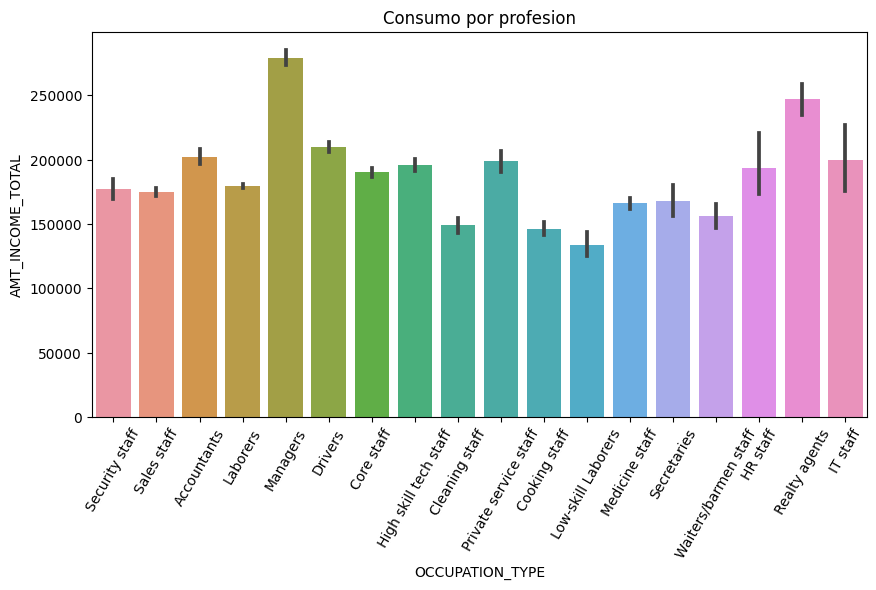

In [32]:

### creando una gráfica de categoría individual para la variable OCCUPATION_TYPE en relación con el poder adquisitivo AMT_INCOME_TOTAL
plt.figure(figsize =(10,5))
ax = sns.barplot(x="OCCUPATION_TYPE", y="AMT_INCOME_TOTAL",data=df3).set_title('Consumo por profesion')
plt.xticks(rotation=60)

### Como hay varias categorias, dividiremos todas ellas por el poder de consumo

In [33]:
#Consumo medio por profesión
df4 = df3.groupby(['OCCUPATION_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df4['AMT_INCOME_TOTAL']

OCCUPATION_TYPE
Managers                 279117.292829
Realty agents            247500.000000
Drivers                  209797.240412
Accountants              202463.865834
IT staff                 199860.000000
Private service staff    198863.372093
High skill tech staff    196053.579176
HR staff                 193764.705882
Core staff               190172.786967
Laborers                 179794.282402
Security staff           177037.753378
Sales staff              174984.897848
Secretaries              168079.470199
Medicine staff           166114.618061
Waiters/barmen staff     156206.896552
Cleaning staff           149141.107078
Cooking staff            146517.251908
Low-skill Laborers       133920.000000
Name: AMT_INCOME_TOTAL, dtype: float64

In [34]:


# Como tenemos 18 profesiones, crearemos un índice de impacto de 5 niveles, según el poder de consumo
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Managers','Realty agents'],5)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Drivers','Accountants','IT staff','Private service staff'],4)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['High skill tech staff','HR staff','Core staff','Laborers'],3)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Security staff','Sales staff','Secretaries','Medicine staff'],2)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].replace(['Waiters/barmen staff','Cleaning staff','Cooking staff','Low-skill Laborers'],1)
df3['OCCUPATION_TYPE'] = df3['OCCUPATION_TYPE'].apply(pd.to_numeric)

In [35]:
df3.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008806,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2,2.0,0,C
30,5008808,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,2,1.0,0,0
35,5008809,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,2,1.0,-22,X
40,5008810,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,2,1.0,0,C
67,5008811,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,2,1.0,0,C


In [36]:
# Haciendo lo mismo para la variable educación
df5 = df3.groupby(['NAME_EDUCATION_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df5['AMT_INCOME_TOTAL']

NAME_EDUCATION_TYPE
Academic degree                  253928.571429
Higher education                 229514.648345
Incomplete higher                202280.664653
Secondary / secondary special    179955.714570
Lower secondary                  165455.614973
Name: AMT_INCOME_TOTAL, dtype: float64

In [37]:
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Academic degree'],5)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Higher education'],4)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Incomplete higher'],3)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Secondary / secondary special'],2)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].replace(['Lower secondary'],1)
df3['NAME_EDUCATION_TYPE'] = df3['NAME_EDUCATION_TYPE'].apply(pd.to_numeric)
print(df3['NAME_EDUCATION_TYPE'].unique())

[2 4 3 1 5]


In [38]:
# Hacer lo mismo con el propósito de usar el crédito
df6 = df3.groupby(['NAME_INCOME_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df6['AMT_INCOME_TOTAL']


NAME_INCOME_TYPE
Pensioner               257538.461538
Commercial associate    218450.592669
State servant           205066.709889
Working                 182547.168800
Student                 159300.000000
Name: AMT_INCOME_TOTAL, dtype: float64

In [39]:
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Pensioner'],5)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Commercial associate'],4)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['State servant'],3)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Working'],2)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].replace(['Student'],1)
df3['NAME_INCOME_TYPE'] = df3['NAME_INCOME_TYPE'].apply(pd.to_numeric)
print(df3['NAME_INCOME_TYPE'].unique())

[2 4 3 1 5]


In [40]:
# Haciendo lo mismo para el tipo de casa
df7 = df3.groupby(['NAME_HOUSING_TYPE']).mean().sort_values(['AMT_INCOME_TOTAL'], ascending=False)
df7['AMT_INCOME_TOTAL']

NAME_HOUSING_TYPE
Office apartment       237812.562814
Co-op apartment        222868.421053
Rented apartment       216431.825740
House / apartment      195017.475251
Municipal apartment    188764.470443
With parents           179850.883217
Name: AMT_INCOME_TOTAL, dtype: float64

In [41]:
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Office apartment'],6)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Co-op apartment'],5)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Rented apartment'],4)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['House / apartment'],3)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['Municipal apartment'],2)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].replace(['With parents'],1)
df3['NAME_HOUSING_TYPE'] = df3['NAME_HOUSING_TYPE'].apply(pd.to_numeric)
print(df3['NAME_HOUSING_TYPE'].unique())

[3 4 2 1 5 6]


In [42]:
df3.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008806,1,1,0,112500.0,2,2,Married,3,-21474,-1134,1,0,0,0,2,2.0,0,C
30,5008808,0,1,0,270000.0,4,2,Single / not married,3,-19110,-3051,1,0,1,1,2,1.0,0,0
35,5008809,0,1,0,270000.0,4,2,Single / not married,3,-19110,-3051,1,0,1,1,2,1.0,-22,X
40,5008810,0,1,0,270000.0,4,2,Single / not married,3,-19110,-3051,1,0,1,1,2,1.0,0,C
67,5008811,0,1,0,270000.0,4,2,Single / not married,3,-19110,-3051,1,0,1,1,2,1.0,0,C


In [43]:
#Como se ve en el gráfico inicial, la variable estado civil no varía mucho en consumo según estado,
#por lo que la eliminaremos junto con otras variables innecesarias

df3 = df3.drop(columns=['NAME_FAMILY_STATUS'])
df3 = df3.drop(columns=['ID'])
#Eliminemos la variable FLAG_MOBIL, CNT_CHILDREN y FLAG_WORK_PHONE porque tampoco trae información relevante
df3 = df3.drop(columns=['FLAG_MOBIL'])
df3 = df3.drop(columns=['FLAG_WORK_PHONE'])
df3 = df3.drop(columns=['CNT_CHILDREN'])
df3 = df3.drop(columns=['FLAG_PHONE'])
df3 = df3.drop(columns=['FLAG_EMAIL'])
df3.head(2)

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,1,1,112500.0,2,2,3,-21474,-1134,2,2.0,0,C
30,0,1,270000.0,4,2,3,-19110,-3051,2,1.0,0,0


In [44]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 0 to 537653
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FLAG_OWN_CAR         25134 non-null  uint8  
 1   FLAG_OWN_REALTY      25134 non-null  uint8  
 2   AMT_INCOME_TOTAL     25134 non-null  float64
 3   NAME_INCOME_TYPE     25134 non-null  int64  
 4   NAME_EDUCATION_TYPE  25134 non-null  int64  
 5   NAME_HOUSING_TYPE    25134 non-null  int64  
 6   DAYS_BIRTH           25134 non-null  int64  
 7   DAYS_EMPLOYED        25134 non-null  int64  
 8   OCCUPATION_TYPE      25134 non-null  int64  
 9   CNT_FAM_MEMBERS      25134 non-null  float64
 10  MONTHS_BALANCE       25134 non-null  int64  
 11  STATUS               25134 non-null  object 
dtypes: float64(2), int64(7), object(1), uint8(2)
memory usage: 2.2+ MB


#### Ahora vamos a analizar la variable target

##### Tenemos dos categorías de personas: con retrasos en los pagos y sin retrasos. Así que los vamos a categorizar como **en cumplimiento y en incumplimiento**. La decisión de quién está en default o en default es relativa y depende de los intereses internos de las instituciones, pero para simplificar el modelo lo haremos así.

Quizás se pregunte si sería interesante estimar una regresión lineal antes de convertir la variable objetivo en una variable ficticia. El caso es que las variables explicativas deben tener una distribución normal para obtener los mejores estimadores de MCO, lo que no ocurre en nuestro conjunto de datos. Por lo tanto, llevaremos nuestro análisis a modelos no lineales. 

In [45]:
df3['STATUS'].unique()

array(['C', '0', 'X', '1', '5', '4', '3', '2'], dtype=object)

In [46]:
#las letras están por defecto y los números por defecto
df3['STATUS'] = df3['STATUS'].replace(['C'],0)
df3['STATUS'] = df3['STATUS'].replace(['X'],0)
df3['STATUS'] = df3['STATUS'].apply(pd.to_numeric) 
df3['STATUS'] = np.where(df3['STATUS']<1, 0, 1)
print(df3['STATUS'].unique())


[0 1]


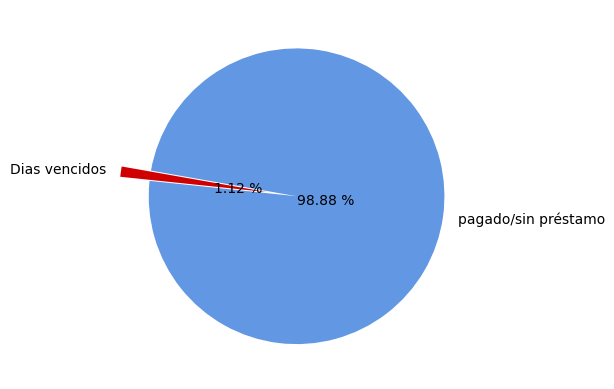

In [47]:
Moroso = df3.loc[df3['STATUS'] == 1].count()[0]
Pagador = df3.loc[df3['STATUS'] == 0].count()[0]

labels = ['Dias vencidos', 'pagado/sin préstamo']
colors = ['#d10000', '#6297e3']
explode = (.1,.1)


plt.pie([Moroso, Pagador], labels = labels, colors = colors, 
        autopct = '%.2f %%', pctdistance= 0.2, startangle=170, explode = explode)
plt.show()

In [48]:
df3['STATUS'].value_counts()

0    24853
1      281
Name: STATUS, dtype: int64

In [49]:
df3['STATUS'].value_counts()/df3.shape[0]

0    0.98882
1    0.01118
Name: STATUS, dtype: float64

Podemos ver que nuestro conjunto de datos es **muy desequilibrado (desbalanceado)** y la proporción de clases es 24853 pagadores frente a 281 morosos. Y para eso vamos a utilizar el método de remuestreo para balancear la base de datos.

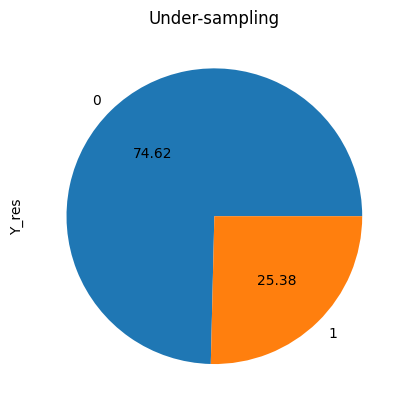

In [50]:
x,y = df3.loc[:,df3.columns != 'STATUS'], df3.loc[:,'STATUS']

# Definir la proporción de datos de clase donde hay menos observaciones
sampling_strategy= 0.34
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(x, y)
autopct = "%.2f"
ax = pd.DataFrame(y_res.values, columns=['Y_res']).Y_res.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("Under-sampling")

<Axes: title={'center': 'Correlation of Features'}>

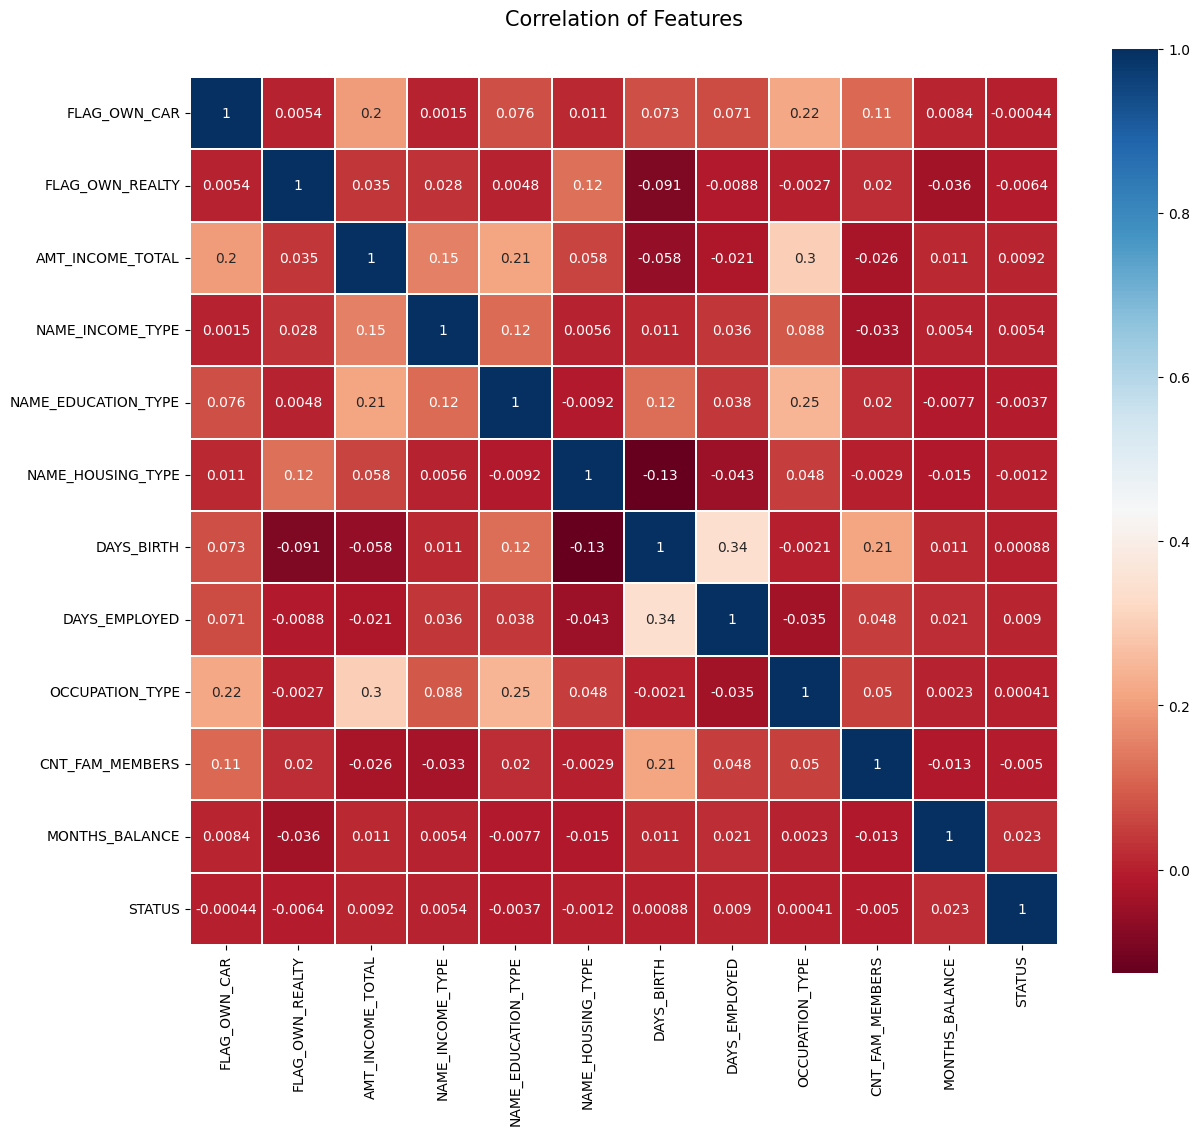

In [51]:
# Llamar a la variable ESTADO de riesgo ayuda a comprender mejor
# Veamos correlaciones
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(df3.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Las variables tienen poca correlación entre sí, lo que puede ser una buena señal, disminuyendo las posibilidades de inflar o sobreajustar (overfit) el modelo.

## Busquemos el mejor modelo


In [55]:

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

In [56]:
# Separando la data

x_train,x_test,y_train,y_test = train_test_split(X_res,y_res,test_size = 0.20,random_state = 1)

x_train_0,x_train_1,y_train_0,y_train_1 = train_test_split(X_res,y_res,test_size = 0.60, random_state = 1)

In [57]:
#X_res, y_res

In [67]:
##creando una lista con los modelos
# Ver cuál tiene la mejor precisión para usarlo en la predicción

models = {}
models['knn'] = KNeighborsClassifier()                #### K-neighbors
models['cart'] = DecisionTreeClassifier()             #### Decision Tree
models['svm'] = SVC()                                 #### Support vector machine
models['bayes'] = GaussianNB()                        #### Naive Bayes
models['rdm'] = RandomForestClassifier()              #### Random Forest
models['lgc'] = LogisticRegression(max_iter=1000)     #### Logistic Reggresion
models['ada'] = AdaBoostClassifier()                  #### Adaboost
models['gda'] = GradientBoostingClassifier()          #### Gradient Boosting
models['bca'] = BaggingClassifier()                   #### Bagging
models['lig'] = lgb.LGBMClassifier()                   #### ligthgbm



Pueden revisar el siguiente link para ver los parámetros de los siguientes modelos:

1. [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

2. [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

3. [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

4. [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

5. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

6. [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

7. [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

8. [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

9. [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [68]:

# Votaremos por el mejor modelo
# Revisando el accuracy
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    accuracy = accuracy_score(y_test,y_pred)
    auc_score = metrics.roc_auc_score( y_test, y_pred )
    print(name, 'Accuracy_train',accuracy_train,'AUC', auc_score,'Accuracy_test',accuracy)
    
    #Análisis de sobreajuste por si hay sospechas usando curva roc

knn Accuracy_train 0.7943502824858757 AUC 0.5372346216657594 Accuracy_test 0.6981981981981982
cart Accuracy_train 0.9830508474576272 AUC 0.6558519324986392 Accuracy_test 0.7207207207207207
svm Accuracy_train 0.7446327683615819 AUC 0.5 Accuracy_test 0.7522522522522522
bayes Accuracy_train 0.7435028248587571 AUC 0.5151878062057703 Accuracy_test 0.7567567567567568
rdm Accuracy_train 0.9830508474576272 AUC 0.6850299401197605 Accuracy_test 0.8288288288288288
lgc Accuracy_train 0.7446327683615819 AUC 0.5 Accuracy_test 0.7522522522522522
ada Accuracy_train 0.768361581920904 AUC 0.542569406641263 Accuracy_test 0.7612612612612613
gda Accuracy_train 0.8497175141242937 AUC 0.5972237343494828 Accuracy_test 0.7792792792792793
bca Accuracy_train 0.9649717514124294 AUC 0.6823625476320087 Accuracy_test 0.7972972972972973
lig Accuracy_train 0.9830508474576272 AUC 0.6492106695699509 Accuracy_test 0.7657657657657657


In [69]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

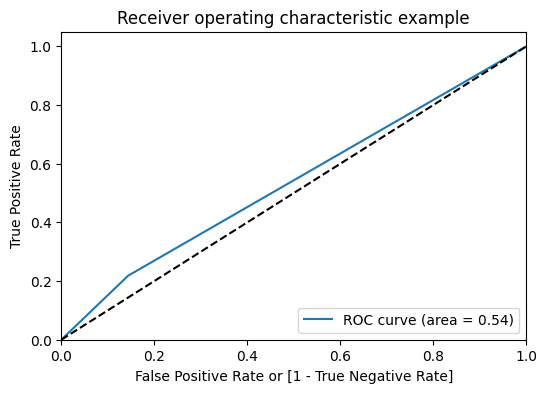

knn 0.6981981981981982


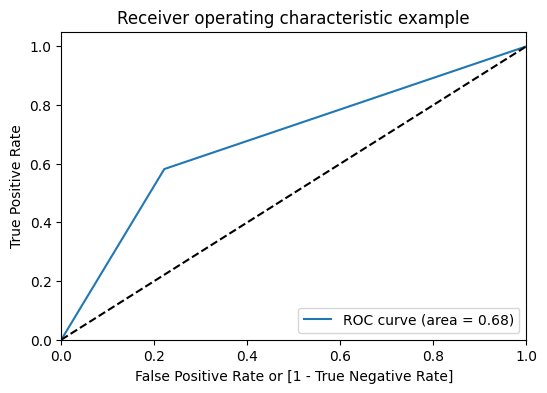

cart 0.7297297297297297


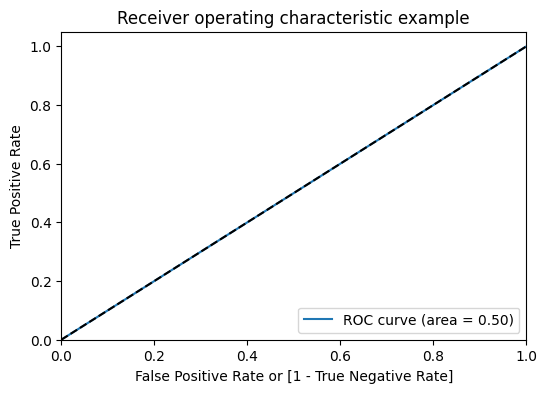

svm 0.7522522522522522


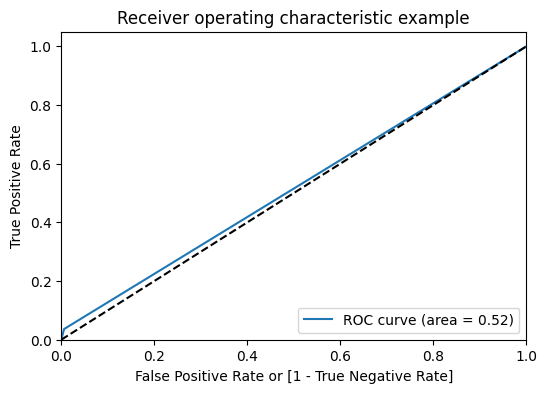

bayes 0.7567567567567568


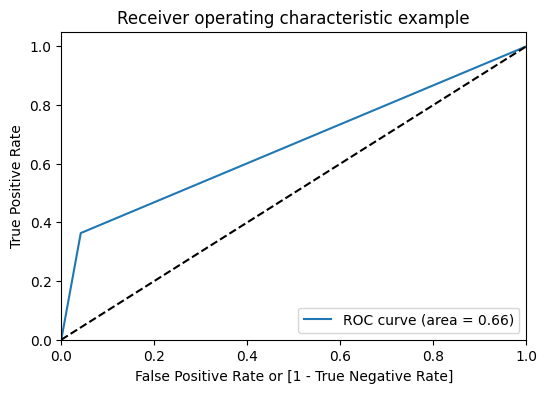

rdm 0.8108108108108109


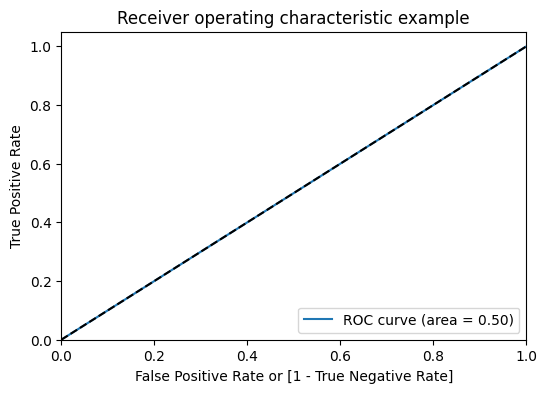

lgc 0.7522522522522522


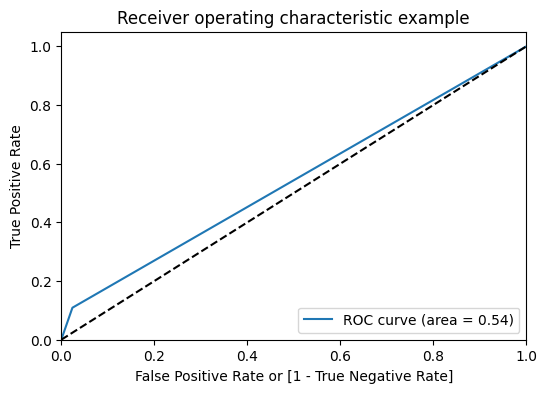

ada 0.7612612612612613


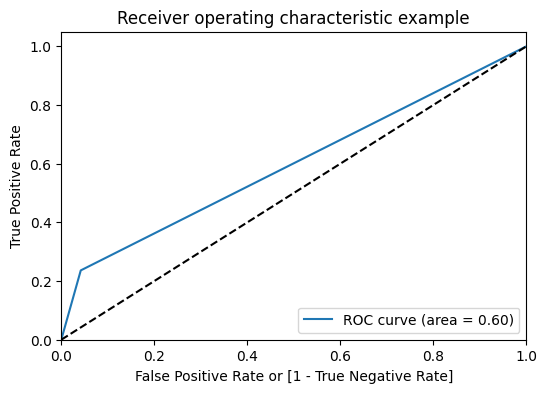

gda 0.7792792792792793


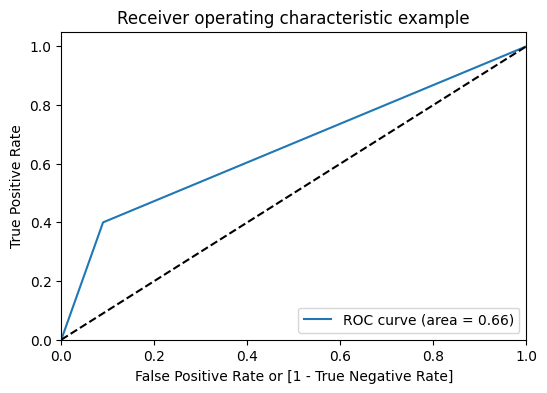

bca 0.7837837837837838


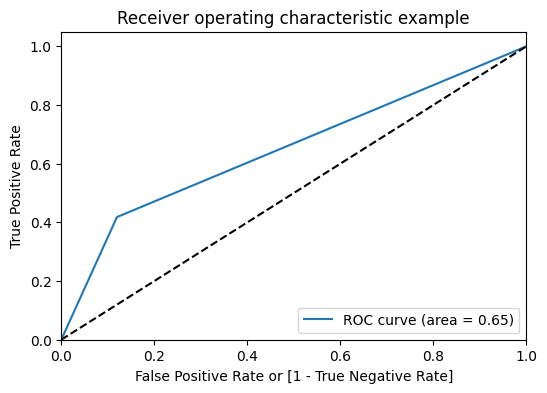

lig 0.7657657657657657


In [70]:
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    fpr, tpr, thresholds = draw_roc( y_test, y_pred )
    print(name, accuracy)


Podemos ver que tres modelos están generando un sobreajuste, así que los vamos a remover

In [71]:
# Corriendo una vez màs
models = {}
models['knn'] = KNeighborsClassifier()                #### K-neighbors
models['cart'] = DecisionTreeClassifier()             #### Decision Tree
models['rdm'] = RandomForestClassifier()              #### Random Forest
models['ada'] = AdaBoostClassifier()                  #### Adaboost
models['gda'] = GradientBoostingClassifier()          #### Gradient Boosting
models['bca'] = BaggingClassifier()                   #### Bagging
models['lig'] = lgb.LGBMClassifier()                   #### ligthgbm

# Accuracy

# Votaremos por el mejor modelo
# Revisando el accuracy
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    print(name, accuracy)

# Comprobación del intervalo de confianza del accuracy
from sklearn.model_selection import cross_val_score    

knn_IC = cross_val_score(models['knn'], X_res,y_res, cv=5)
cart_IC = cross_val_score(models['cart'], X_res,y_res, cv=5)
rdm_IC = cross_val_score(models['rdm'], X_res,y_res, cv=5)
gda_IC = cross_val_score(models['gda'], X_res,y_res, cv=5)
ada_IC = cross_val_score(models['ada'], X_res,y_res, cv=5)
bca_IC = cross_val_score(models['bca'], X_res,y_res, cv=5)
lig_IC = cross_val_score(models['lig'], X_res,y_res, cv=5)
scores = {}

scores['knn'] =  knn_IC.mean() + knn_IC.std() * 2, knn_IC.mean() - knn_IC.std() * 2
scores['cart'] =  cart_IC.mean() + cart_IC.std() * 2, cart_IC.mean() - cart_IC.std() * 2
scores['rdm'] =   rdm_IC.mean() + rdm_IC.std() * 2,rdm_IC.mean() - rdm_IC.std() * 2
scores['gda'] =  gda_IC.mean() + gda_IC.std() * 2, gda_IC.mean() - gda_IC.std() * 2
scores['ada'] =  ada_IC.mean() + ada_IC.std() * 2, ada_IC.mean() - ada_IC.std() * 2
scores['bca'] =  bca_IC.mean() + bca_IC.std() * 2, bca_IC.mean() - bca_IC.std() * 2
scores['lig'] =  lig_IC.mean() + lig_IC.std() * 2, lig_IC.mean() - lig_IC.std() * 2
#Intervalo de confianza 
scores




knn 0.6981981981981982
cart 0.7297297297297297
rdm 0.7972972972972973
ada 0.7612612612612613
gda 0.7792792792792793
bca 0.7522522522522522
lig 0.7657657657657657


{'knn': (0.7548274566520884, 0.6435174946340393),
 'cart': (0.7166885152436955, 0.5842205386065347),
 'rdm': (0.770495967469224, 0.7091991122258559),
 'gda': (0.7401370696002749, 0.7142267965282971),
 'ada': (0.7684428722070613, 0.7076078391377678),
 'bca': (0.7667934985250162, 0.6713704572859986),
 'lig': (0.7410272654757456, 0.6880869165796132)}

In [72]:
#Evaluar el rendimiento de modelos que tienen precisión dentro del rango 


from sklearn.metrics import classification_report
models = {}
models['knn'] = KNeighborsClassifier()                #### K-neighbors
models['cart'] = DecisionTreeClassifier()             #### Decision Tree
models['rdm'] = RandomForestClassifier()              #### Random Forest
models['ada'] = AdaBoostClassifier()                  #### Adaboost
models['gda'] = GradientBoostingClassifier()          #### Gradient Boosting
models['bca'] = BaggingClassifier()                   #### Bagging
models['lig'] = lgb.LGBMClassifier()                   #### ligthgbm


for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    classification = classification_report(y_test,y_pred)
    print(name, classification)

knn               precision    recall  f1-score   support

           0       0.77      0.86      0.81       167
           1       0.33      0.22      0.26        55

    accuracy                           0.70       222
   macro avg       0.55      0.54      0.54       222
weighted avg       0.66      0.70      0.67       222

cart               precision    recall  f1-score   support

           0       0.84      0.76      0.80       167
           1       0.44      0.56      0.49        55

    accuracy                           0.71       222
   macro avg       0.64      0.66      0.65       222
weighted avg       0.74      0.71      0.72       222

rdm               precision    recall  f1-score   support

           0       0.81      0.92      0.87       167
           1       0.61      0.36      0.45        55

    accuracy                           0.78       222
   macro avg       0.71      0.64      0.66       222
weighted avg       0.76      0.78      0.76       222

ada   

#### Vea cómo la Accuracy puede inducir a error a la elección del modelo. , Por ejemplo el modelo ada tiene un alto accuracy del 75% sin embargo si vemos el recall es bastante bajo 11%.

#¿Cuál es la importancia de analizar la Recall de los modelos de credit scoring?

####   Cuando una empresa de crédito desea otorgar crédito a sus clientes, no solo analiza la precisión de los modelos. De hecho, esto constituye la parte más pequeña del análisis crediticio. Dadas las condiciones internas de la institución, siempre existe un grado de riesgo en la aplicación de productos financieros, y de acuerdo con la situación interna de la empresa, determinará qué persona recibirá su crédito. Por tanto, el punto que más afecta a quienes recibirán el crédito, es saber cuál es la probabilidad de que un cliente con determinadas características se convierta en un posible moroso, y con ello saber cuál es su probabilidad de tener morosidad, o no liquidar. la deuda., y así determinar el punto de corte según el grado de riesgo que la institución haya elegido. Por ejemplo, el banco X no aumentará el límite de la tarjeta de crédito para los clientes que tienen más del 30% de probabilidades de incurrir en incumplimiento. Esto equivale a determinar un punto de corte de 0,3. Es decir, en las decisiones de quién recibirá crédito o no, no es la precisión(accuracy) lo que nos brinda el mejor desempeño del modelo, sino su desempeño en cuanto a variaciones en los puntos de corte, obtenidos por el AUC de la curva ROC. que se extrae de Recall.

Para más información respecto al [Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

#### En nuestro caso, el único modelo que tuvo la menor capacidad para clasificar los positivos, fue el Beysiano. Hagamos que las AUC se comparen.

In [73]:
from sklearn.metrics import roc_auc_score

modelsknn = KNeighborsClassifier().fit(x_train, y_train)                #### K-neighbors
modelscart = DecisionTreeClassifier() .fit(x_train, y_train)            #### Decision Tree
modelsrdm = RandomForestClassifier().fit(x_train, y_train)              #### Random Forest
modelsada = AdaBoostClassifier().fit(x_train, y_train)                  #### Adaboost
modelsgda = GradientBoostingClassifier().fit(x_train, y_train)          #### Gradient Boosting
modelsbca = BaggingClassifier().fit(x_train, y_train)                   #### Bagging
modelslig = lgb.LGBMClassifier().fit(x_train, y_train)                   #### ligthgbm



y_knn =  modelsknn.predict(x_test)
y_cart =  modelscart.predict(x_test)
y_rdm =  modelsrdm.predict(x_test)
y_ada =  modelsada.predict(x_test)
y_gda =  modelsgda.predict(x_test)
y_bca =  modelsbca.predict(x_test)
y_lig =  modelslig.predict(x_test)
    
    
auc = {}
auc['knn'] = roc_auc_score(y_test, y_knn)
auc['cart'] = roc_auc_score(y_test, y_cart)
auc['rdm'] = roc_auc_score(y_test, y_rdm)
auc['ada'] = roc_auc_score(y_test, y_ada)
auc['gda'] = roc_auc_score(y_test, y_gda)
auc['bca'] = roc_auc_score(y_test, y_bca)
auc['lig'] = roc_auc_score(y_test, y_lig)

auc


{'knn': 0.5372346216657594,
 'cart': 0.6680457267283615,
 'rdm': 0.6426782798040283,
 'ada': 0.542569406641263,
 'gda': 0.5972237343494828,
 'bca': 0.6309199782253675,
 'lig': 0.6492106695699509}

In [68]:
#El mejor modelo fue el modelo boosting, a este modelo le aplicaremos una mejorar a sus hyperparametros
# modelo boosting

In [76]:
import optuna
def objective(trial):
    # Definir los rangos de búsqueda de los hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 10, 100)# se sugieren valores desde el 10 al 100
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 2, 10)
    
    # Crear un clasificador Random Forest con los hiperparámetros seleccionados
    clf = lgb.LGBMClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_child_samples=min_child_samples,
                                  random_state=42)
    
    # Entrenar y evaluar el modelo
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Crear un objeto de estudio Optuna
study = optuna.create_study(direction='maximize')

# Ejecutar la optimización de hiperparámetros
study.optimize(objective, n_trials=50)

# Obtener los hiperparámetros óptimos
best_params = study.best_params
print(f'Hiperparámetros óptimos: {best_params}')

[I 2023-04-03 19:03:51,701] A new study created in memory with name: no-name-438a176c-a05f-4495-bed1-02eb6380328c
[I 2023-04-03 19:03:51,805] Trial 0 finished with value: 0.7657657657657657 and parameters: {'n_estimators': 39, 'max_depth': 5, 'min_child_samples': 10}. Best is trial 0 with value: 0.7657657657657657.
[I 2023-04-03 19:03:51,924] Trial 1 finished with value: 0.7792792792792793 and parameters: {'n_estimators': 86, 'max_depth': 5, 'min_child_samples': 10}. Best is trial 1 with value: 0.7792792792792793.
[I 2023-04-03 19:03:51,983] Trial 2 finished with value: 0.7747747747747747 and parameters: {'n_estimators': 42, 'max_depth': 4, 'min_child_samples': 4}. Best is trial 1 with value: 0.7792792792792793.
[I 2023-04-03 19:03:52,222] Trial 3 finished with value: 0.7702702702702703 and parameters: {'n_estimators': 92, 'max_depth': 10, 'min_child_samples': 6}. Best is trial 1 with value: 0.7792792792792793.
[I 2023-04-03 19:03:52,303] Trial 4 finished with value: 0.7747747747747747

[I 2023-04-03 19:03:57,066] Trial 38 finished with value: 0.7657657657657657 and parameters: {'n_estimators': 10, 'max_depth': 8, 'min_child_samples': 3}. Best is trial 32 with value: 0.7972972972972973.
[I 2023-04-03 19:03:57,227] Trial 39 finished with value: 0.7837837837837838 and parameters: {'n_estimators': 35, 'max_depth': 9, 'min_child_samples': 4}. Best is trial 32 with value: 0.7972972972972973.
[I 2023-04-03 19:03:57,381] Trial 40 finished with value: 0.7882882882882883 and parameters: {'n_estimators': 46, 'max_depth': 10, 'min_child_samples': 2}. Best is trial 32 with value: 0.7972972972972973.
[I 2023-04-03 19:03:57,571] Trial 41 finished with value: 0.7882882882882883 and parameters: {'n_estimators': 47, 'max_depth': 10, 'min_child_samples': 2}. Best is trial 32 with value: 0.7972972972972973.
[I 2023-04-03 19:03:57,735] Trial 42 finished with value: 0.7882882882882883 and parameters: {'n_estimators': 46, 'max_depth': 10, 'min_child_samples': 2}. Best is trial 32 with valu

Hiperparámetros óptimos: {'n_estimators': 48, 'max_depth': 9, 'min_child_samples': 2}


In [78]:
lg_model_tuneado =  lgb.LGBMClassifier(n_estimators=48, max_depth=9,min_child_samples=2)
lg_model_tuneado.fit(x_train, y_train)
y_pred = lg_model_tuneado.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7972972972972973


In [ ]:
#Finalmente guarde su modelo y pongalo en produccion

In [79]:
#guardando el modelo final
from pickle import dump
from pickle import load
def guardar_modelo(model,nombre):
    output = open(nombre, 'wb')
    dump(model, output , -1)
    output.close()
#cargar modelo 
def cargar_modelo(nombre):
    input = open(nombre, 'rb')
    modelo = load(input)
    input.close()
    return modelo

In [80]:
nombre = 'modelo.pkl'
guardar_modelo(model,nombre)

In [81]:
modelo_final = cargar_modelo(nombre)

In [82]:
modelo_final.predict(x_test)

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1])